In [1]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
from torchvision import transforms

from pytorch_accelerated.callbacks import SaveBestModelCallback, ProgressBarCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS
from pytorch_accelerated.run_config import TrainerRunConfig
from pytorch_accelerated.utils import local_process_zero_only

from PIL import Image

from tqdm.auto import tqdm
import time
import pandas as pd

from accelerate import notebook_launcher
import accelerate

from torch.utils.data import Dataset
import numpy as np
import glob

class PCBData(Dataset):
    def __init__(self, root_dir, transform=None, stage='val'):
        self.root_dir = root_dir
        self.transform = transform
        image_files = np.array(sorted(glob.glob(root_dir+'/**/*.bmp', recursive=True)))
        image_labels = np.array([ 0 if filename.split('/')[1]=='TRUE' else 1 for filename in image_files])
        train_ratio = 0.8
        val_ratio = 0.1
        n_all = len(image_labels)
        n_ng = len(image_labels[image_labels==0])
        n_ok = n_all - n_ng
        ng_indices = np.array([i for i in range(n_ng)])
        ok_indices = np.array([i for i in range(n_ng, n_all)])
        np.random.seed(45)
        ng_perm = np.random.permutation(ng_indices)
        n_ng_train = int(n_ng*0.8)
        n_ng_val = int(n_ng*0.1)
        ng_train_indices = ng_perm[:n_ng_train]
        ng_val_indices = ng_perm[n_ng_train:n_ng_train+n_ng_val]
        ng_test_indices = ng_perm[n_ng_train+n_ng_val:]
        ok_perm = np.random.permutation(ok_indices)
        n_ok_train = int(n_ok*0.8)
        n_ok_val = int(n_ok*0.1)
        ok_train_indices = ok_perm[:n_ok_train]
        ok_val_indices = ok_perm[n_ok_train:n_ok_train+n_ok_val]
        ok_test_indices = ok_perm[n_ok_train+n_ok_val:]
        train_indices = np.concatenate((ng_train_indices, ok_train_indices))
        val_indices = np.concatenate((ng_val_indices, ok_val_indices))
        test_indices = np.concatenate((ng_test_indices, ok_test_indices))
        if stage == 'train':
            indices = train_indices
        elif stage == 'val':
            indices = val_indices
        else:
            indices = test_indices
        self.files = list(zip(image_files[indices], image_labels[indices]))
        if stage == 'd_train':
            image_files = np.array(sorted(glob.glob('PCB_data'+'/**/*.jpg', recursive=True)))
            image_labels = np.array([ 0 if filename.split('/')[1]=='NG' else 1 for filename in image_files])
            self.files += list(zip(image_files, image_labels))
        '''
        self.classes = ['NG', 'OK']
        self.files = []
        for index, label in enumerate(self.classes):
            path = os.path.join(self.root_dir, label)
            files = os.listdir(path)
            for file in files:
                self.files.append((os.path.join(path, file), index))
        '''

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def img_file(self, idx):
        return self.files[idx]

class TQDM_progressbar(ProgressBarCallback):
    """
    A callback which visualises the state of each training and evaluation epoch using a progress bar
    """

    def __init__(self):
        self.pbar = None

    def on_train_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._train_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_train_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_train_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

    def on_eval_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._eval_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_eval_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_eval_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

class ImageDataset_new(timm.data.dataset.ImageDataset):
    def __init__(
            self,
            root,
            reader=None,
            split='train',
            class_map=None,
            load_bytes=False,
            input_img_mode='RGB',
            transform=None,
            target_transform=None,
    ):
        super().__init__(root, reader, split, class_map, load_bytes, input_img_mode, transform, target_transform)
        
    def __getitem__(self, index):
        img, target = self.reader[index]

        '''
        try:
            img = img.read() if self.load_bytes else Image.open(img)
        except Exception as e:
            _logger.warning(f'Skipped sample (index {index}, file {self.reader.filename(index)}). {str(e)}')
            self._consecutive_errors += 1
            if self._consecutive_errors < _ERROR_RETRY:
                return self.__getitem__((index + 1) % len(self.reader))
            else:
                raise e
        '''
        self._consecutive_errors = 0

        with Image.open(img) as im:
            if self.input_img_mode and not self.load_bytes:
                img = im.convert(self.input_img_mode)
            
        if self.transform is not None:
            img = self.transform(img)

        if target is None:
            target = -1
        elif self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

import random
from typing import Sequence

class RotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles
        self.count = 0

    def __call__(self, x):
        angle = random.choice(self.angles)
        if angle == 0:
            return x
        else:
            return transforms.functional.rotate(x, angle)

#def create_datasets(image_size, data_mean, data_std, train_path, val_path):
def create_datasets(image_size, data_mean, data_std, path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            #transforms.Resize((224,224)),
            transforms.Resize((384,384)),
            #transforms.RandomCrop((224,224)),
            transforms.RandomVerticalFlip(),  # 상하반전 
            transforms.RandomHorizontalFlip(),  # 좌우반전 
            transforms.RandomApply([transforms.RandomRotation(90)], p=0.5),
            #RotateTransform([0,90,180,270]),
            #transforms.RandomHorizontalFlip(),  # 좌우반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            #transforms.Resize((224,224)),
            transforms.Resize((384,384)),
            #transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    '''
    from torchvision import datasets
    train_dataset = datasets.ImageFolder(train_path, train_transforms)
    eval_dataset = datasets.ImageFolder(val_path, eval_transforms)

    return train_dataset, eval_dataset
    '''
    data_dir = 'pcb_test'
    train_dataset = PCBData(data_dir, transform=train_transforms, stage='train')
    val_dataset = PCBData(data_dir, transform=eval_transforms, stage='val')
    test_dataset = PCBData(data_dir, transform=eval_transforms, stage='test')

    return train_dataset, val_dataset, test_dataset


class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        #self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-5,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        #mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        #return super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        return super().calculate_train_batch_loss((xb, yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

        # learning rate log
        self.run_history.update_metric("lr", self.optimizer.param_groups[0]['lr'])

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            if self.ema_model is not None:
                ema_model_preds = self.ema_model.module(xb).argmax(-1)
                self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()

data_path='PCB_data'
# Set training arguments, hardcoded here for clarity
image_size = (224, 224)
#lr = 5e-3
lr = 0.00010
smoothing = 0.1
mixup = 0.2
cutmix = 1.0
batch_size = 64
bce_target_thresh = 0.2
num_epochs = 20

data_path = Path(data_path)
train_path = data_path / "train"
val_path = data_path / "val"

num_classes = len(list(data_path.iterdir()))

mixup_args = dict(
    mixup_alpha=mixup,
    cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=num_classes,
)

# Create model using timm
model = timm.create_model(
    #"resnet50d", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"efficientnet_b4.ra2_in1k", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"davit_tiny", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"davit_tiny", pretrained=True, num_classes=num_classes
    #"efficientvit_b3.r224_in1k", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_clip_224.openai", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_clip_384.openai_ft_in12k_in1k", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_224", pretrained=True, num_classes=num_classes
    "vit_small_patch16_384", pretrained=True, num_classes=num_classes, 
    #"vit_tiny_patch16_384", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

class PCB_model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()

        self.backbone = model 
        #self.softmax = torch.nn.Softmax(dim=1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.softmax(x)
        return x

model = PCB_model(model)

# Create training and validation datasets
train_dataset, eval_dataset, test_dataset = create_datasets(
    path = data_path,
    #train_path=train_path,
    #val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

def my_train():
    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(
        model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    #train_loss_fn = timm.loss.BinaryCrossEntropy(
    #    target_threshold=bce_target_thresh, smoothing=smoothing
    #)
    #train_loss_fn = torch.nn.CrossEntropyLoss()
    #validate_loss_fn = torch.nn.CrossEntropyLoss()
    train_loss_fn = torch.nn.NLLLoss()
    validate_loss_fn = torch.nn.NLLLoss()

    default_callbacks = list(DEFAULT_CALLBACKS)
    default_callbacks.pop(3)

    # Create trainer and start training
    trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            #*DEFAULT_CALLBACKS,
            *default_callbacks,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            TQDM_progressbar,
        ],
    )

    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
        gradient_clip_value=1.0,
    )
    
    @local_process_zero_only
    def save_history():
        #print(trainer.run_history.get_metric_names())
        train_loss_epoch = trainer.run_history.get_metric_values('train_loss_epoch')
        eval_loss_epoch = trainer.run_history.get_metric_values('eval_loss_epoch')
        accuracy = trainer.run_history.get_metric_values('accuracy')
        accuracy = [acc.numpy() for acc in accuracy]
        lr = trainer.run_history.get_metric_values('lr')
        df = pd.DataFrame(data={'train_loss': train_loss_epoch,
                                'val_loss': eval_loss_epoch,
                                'val_acc': accuracy,
                                'lr': lr,
                               })
        df.to_csv('train_history.csv', index=False)
        #print(trainer.scheduler._get_lr())

    save_history()
    
    #trainer.evaluate(
    #    per_device_batch_size=batch_size,
    #    dataset=eval_dataset,
    #)

'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Simple example of training script using timm.")
    parser.add_argument("--data_dir", required=True, help="The data folder on disk.")
    #args = parser.parse_args(args=['--data_dir=imagenette2-320'])
    args = parser.parse_args(args=['--data_dir=PCBData'])
    main(args.data_dir)
'''

notebook_launcher(my_train, num_processes=4)
#my_train()

model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

Launching training on 4 GPUs.


/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:696: UserWarning: The per device batch size 64 with the eval dataset size 928 and the number of processes 4 will cause at least one process to have no samples on the last batch, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by setting a different batch size
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:696: UserWarning: The per device batch size 64 with the eval dataset size 928 and the number of processes 4 will cause at least one process to have no samples on the last batch, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by setting a different batch size
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:696: UserWarning: The per device batch size 64 with the eval dataset size 928 and the number of processes 4 will 


Starting training run

Starting epoch 1


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.5940194725990295


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.7446120977401733

ema_model_accuracy: 0.6282327771186829

eval_loss_epoch: 0.521096408367157

lr: 1e-05

Starting epoch 2


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.3875809907913208


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9116379022598267

ema_model_accuracy: 0.6756465435028076

eval_loss_epoch: 0.23290026187896729

lr: 7.000000000000001e-05

Starting epoch 3


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.2525325417518616


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9181034564971924

ema_model_accuracy: 0.7155172228813171

eval_loss_epoch: 0.1908572018146515

lr: 9.460482294732421e-05

Starting epoch 4


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.21996542811393738


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9375

ema_model_accuracy: 0.7392241358757019

eval_loss_epoch: 0.18813128769397736

lr: 9.05463412215599e-05

Starting epoch 5


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.19481316208839417


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9321120977401733

ema_model_accuracy: 0.7834051847457886

eval_loss_epoch: 0.1851000189781189

lr: 8.55017856687341e-05

Starting epoch 6


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.17290206253528595


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.943965494632721

ema_model_accuracy: 0.8232758641242981

eval_loss_epoch: 0.16437704861164093

lr: 7.959536998847742e-05

Starting epoch 7


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.16301530599594116


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9428879022598267

ema_model_accuracy: 0.8653017282485962

eval_loss_epoch: 0.16058480739593506

lr: 7.297252973710757e-05

Starting epoch 8


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.1503681242465973


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9471982717514038

ema_model_accuracy: 0.892241358757019

eval_loss_epoch: 0.16414353251457214

lr: 6.57963412215599e-05

Starting epoch 9


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.14781545102596283


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9418103694915771

ema_model_accuracy: 0.9116379022598267

eval_loss_epoch: 0.16276533901691437

lr: 5.8243506019491436e-05

Starting epoch 10


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.14645430445671082


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.943965494632721

ema_model_accuracy: 0.9148706793785095

eval_loss_epoch: 0.15936201810836792

lr: 5.05e-05

Starting epoch 11


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.1358303278684616


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9482758641242981

ema_model_accuracy: 0.9159482717514038

eval_loss_epoch: 0.1616058647632599

lr: 4.2756493980508586e-05

Starting epoch 12


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.12644067406654358


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9525862336158752

ema_model_accuracy: 0.9159482717514038

eval_loss_epoch: 0.1596517413854599

lr: 3.5203658778440106e-05

Starting epoch 13


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.11638621985912323


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9504310488700867

ema_model_accuracy: 0.920258641242981

eval_loss_epoch: 0.16205015778541565

lr: 2.8027470262892437e-05

Starting epoch 14


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.1085590049624443


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9504310488700867

ema_model_accuracy: 0.931034505367279

eval_loss_epoch: 0.16208671033382416

lr: 2.1404630011522586e-05

Starting epoch 15


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.1065269336104393


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9504310488700867

ema_model_accuracy: 0.9331896305084229

eval_loss_epoch: 0.16284742951393127

lr: 1.54982143312659e-05

Starting epoch 16


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.10434797406196594


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.951508641242981

ema_model_accuracy: 0.9375

eval_loss_epoch: 0.16222350299358368

lr: 1.0453658778440109e-05

Starting epoch 17


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.09947959333658218


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.951508641242981

ema_model_accuracy: 0.9396551847457886

eval_loss_epoch: 0.1639793962240219

lr: 6.395177052675795e-06

Starting epoch 18


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.09851377457380295


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.951508641242981

ema_model_accuracy: 0.9418103694915771

eval_loss_epoch: 0.16453151404857635

lr: 3.4227024433899e-06

Starting epoch 19


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.0980214923620224


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.951508641242981

ema_model_accuracy: 0.9450430870056152

eval_loss_epoch: 0.16367734968662262

lr: 1.6094271405406859e-06

Starting epoch 20


  0%|          | 0/30 [00:00<?, ?it/s]


train_loss_epoch: 0.09692034125328064


  0%|          | 0/4 [00:00<?, ?it/s]


accuracy: 0.9493534564971924

ema_model_accuracy: 0.9461206793785095

eval_loss_epoch: 0.16351717710494995

lr: 1e-06
Finishing training run
Loading checkpoint with accuracy: 0.9525862336158752 from epoch 12


In [2]:
model

PCB_model(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')

In [3]:
!cp train_history.csv train_history_vit.csv
!cp best_model.pt best_model_vit.pt

In [4]:
df = pd.read_csv('train_history_vit.csv')
df

train_loss  val_loss   val_acc        lr
0     0.594019  0.521096  0.744612  0.000010
1     0.387581  0.232900  0.911638  0.000070
2     0.252533  0.190857  0.918103  0.000095
3     0.219965  0.188131  0.937500  0.000091
4     0.194813  0.185100  0.932112  0.000086
5     0.172902  0.164377  0.943966  0.000080
6     0.163015  0.160585  0.942888  0.000073
7     0.150368  0.164144  0.947198  0.000066
8     0.147815  0.162765  0.941810  0.000058
9     0.146454  0.159362  0.943966  0.000051
10    0.135830  0.161606  0.948276  0.000043
11    0.126441  0.159652  0.952586  0.000035
12    0.116386  0.162050  0.950431  0.000028
13    0.108559  0.162087  0.950431  0.000021
14    0.106527  0.162847  0.950431  0.000015
15    0.104348  0.162224  0.951509  0.000010
16    0.099480  0.163979  0.951509  0.000006
17    0.098514  0.164532  0.951509  0.000003
18    0.098021  0.163677  0.951509  0.000002
19    0.096920  0.163517  0.949353  0.000001

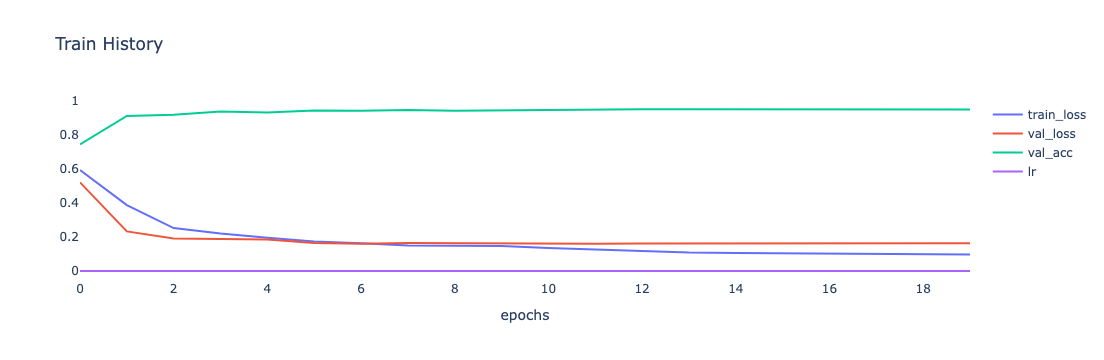

In [5]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot



data = [go.Scatter(x=df.index,
                   y=df[col],
                   name=col) for col in df.columns]

layout = go.Layout(
    plot_bgcolor="white",
    title='Train History',
    xaxis=dict(title='epochs')
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [6]:
import timm
import timm.optim
# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
)

# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()
eval_trainer = TimmMixupTrainer(
    model=model,
    optimizer=optimizer,
    loss_func=train_loss_fn,
    eval_loss_fn=validate_loss_fn,
    mixup_args=mixup_args,
    num_classes=num_classes,
    callbacks=[
        *DEFAULT_CALLBACKS,
        #TQDM_progressbar,
    ],
)
eval_trainer.load_checkpoint('best_model.pt', load_optimizer=False)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=eval_dataset,
      )


Starting evaluation run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  5.95it/s]/home/kotech/venv-lightning/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning:

The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.77it/s]


ema_model_accuracy: 0.0

evaluation_loss: 0.1596517413854599

accuracy: 0.9525862336158752
Finishing evaluation run


In [7]:
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=test_dataset,
      )


Starting evaluation run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.55it/s]


ema_model_accuracy: 0.0

evaluation_loss: 0.1845744401216507

accuracy: 0.9387096762657166
Finishing evaluation run


In [8]:
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=train_dataset,
      )


Starting evaluation run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:21<00:00, 10.73it/s]


accuracy: 0.9520925879478455

ema_model_accuracy: 0.0

evaluation_loss: 0.13505803048610687
Finishing evaluation run


In [6]:
def create_eval_datasets(image_size, data_mean, data_std, train_path, val_path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            #transforms.CenterCrop((224,224)),
            #transforms.RandomCrop((224,224)),
            #transforms.RandomHorizontalFlip(),  # 좌우반전 
            #RotateTransform([0,90,180,270]),
            #transforms.RandomVerticalFlip(),  # 상하반전 
            #transforms.RandomVerticalFlip(),  # 상하반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            #transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    from torchvision import datasets
    #train_dataset = datasets.ImageFolder(train_path, train_transforms)
    #eval_dataset = datasets.ImageFolder(val_path, eval_transforms)
    train_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='train')
    val_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='val')
    test_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='test')

    return train_dataset, val_dataset, test_dataset
    
train2_dataset, val2_dataset, test2_dataset = create_eval_datasets(
    train_path=train_path,
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=train2_dataset,
      )


Starting evaluation run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:10<00:00, 30.18it/s]


evaluation_loss: 0.08582794666290283

accuracy: 0.9654124975204468

ema_model_accuracy: 0.0
Finishing evaluation run


https://github.com/huggingface/accelerate/blob/main/examples/cv_example.py

In [15]:
#model.load_state_dict(torch.load('best_model_res.pt')['model_state_dict'])
device = torch.device('cuda')
#model.to(device)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=64)
y_pred = []
y_true = []
for i, batch in enumerate(eval_dataloader):
    # We could avoid this line since we set the accelerator with `device_placement=True`.
    x, y = batch
    x = x.to(device)
    with torch.no_grad():
        outputs = model(x)
    predictions = outputs.argmax(dim=-1).to('cpu')
    y_pred.append(predictions)
    y_true.append(y)
    #print(predictions)
    #print(y)
    #predictions, references = accelerator.gather_for_metrics((predictions, batch["label"]))
    #accurate_preds = predictions == references
    #num_elems += accurate_preds.shape[0]
    #accurate += accurate_preds.long().sum()

In [16]:
y_pred = torch.cat(y_pred).numpy()
y_true = torch.cat(y_true).numpy()

In [17]:
# accuracy
acc = (y_true == y_pred).sum()/len(y_pred)
print('accuracy =', acc)

accuracy = 0.947198275862069


accuracy_score: 0.947198275862069
              precision    recall  f1-score   support

           0     0.9434    0.9664    0.9548       535
           1     0.9526    0.9211    0.9366       393

    accuracy                         0.9472       928
   macro avg     0.9480    0.9437    0.9457       928
weighted avg     0.9473    0.9472    0.9471       928



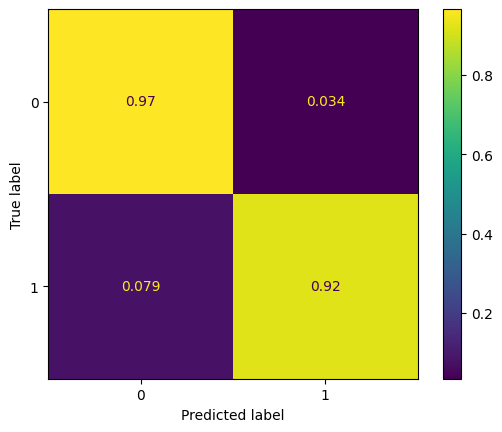

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print('accuracy_score:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))
c = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

In [19]:
dataset = eval_dataset
n_data = len(dataset)
indices = np.array([i for i in range(n_data)])

In [20]:
print(n_data)
print(len(indices[(y_true==0)&(y_pred==1)]))
print(len(indices[(y_true==1)&(y_pred==0)]))
print(len(indices[y_true!=y_pred]))
print(len(indices[y_true==y_pred]))

928
18
31
49
879


In [14]:
1219/1275

0.956078431372549

In [16]:
dataset.img_file(0)

('PCB_data/NG/img3674.jpg', 0)

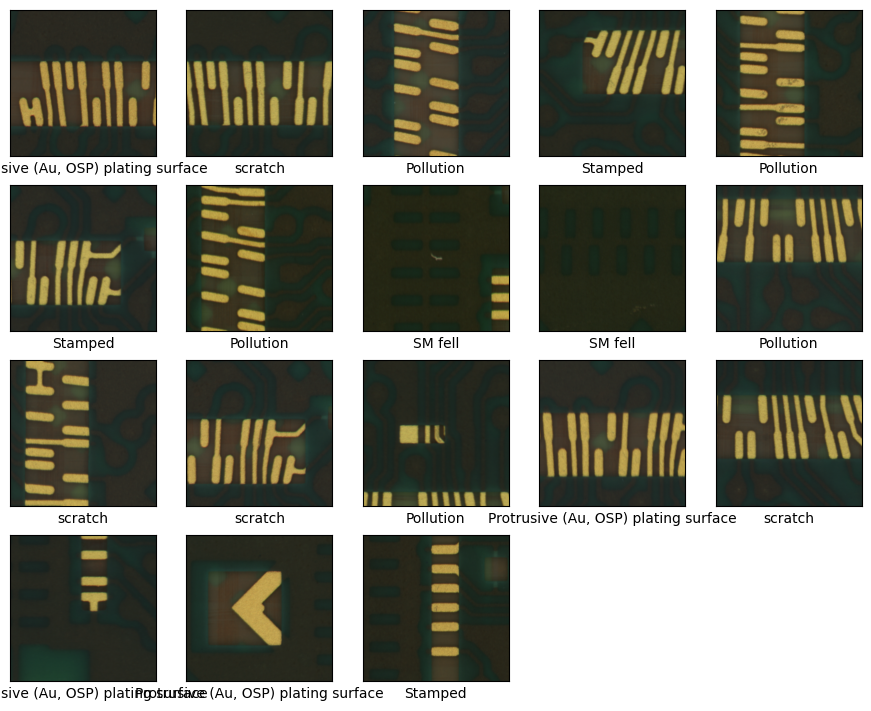

In [27]:
from matplotlib import image as mp_image
import numpy as np

plt.figure(figsize=(11,11))

indices_01 =indices[(y_true==0)&(y_pred==1)] 
perm = np.random.permutation(indices_01)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    plt.xlabel(dataset.img_file(idx)[0].split('/')[2])
plt.show()

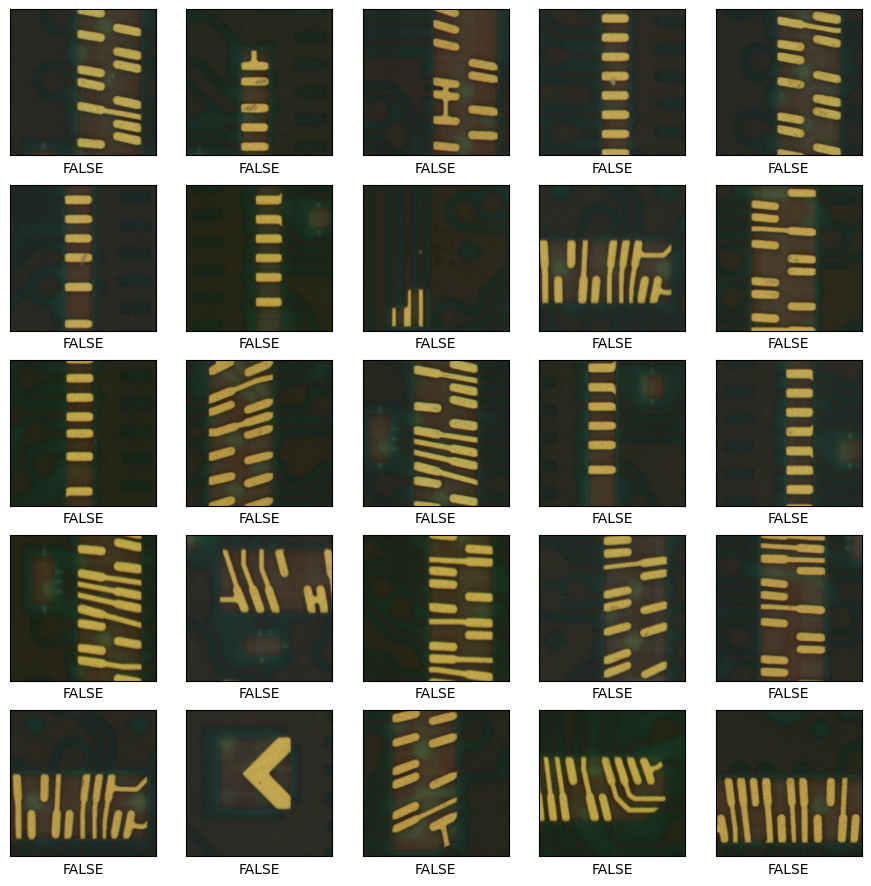

In [28]:
plt.figure(figsize=(11,11))

indices_10 =indices[(y_true==1)&(y_pred==0)] 
perm = np.random.permutation(indices_10)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    plt.xlabel(dataset.img_file(idx)[0].split('/')[1])
plt.show()

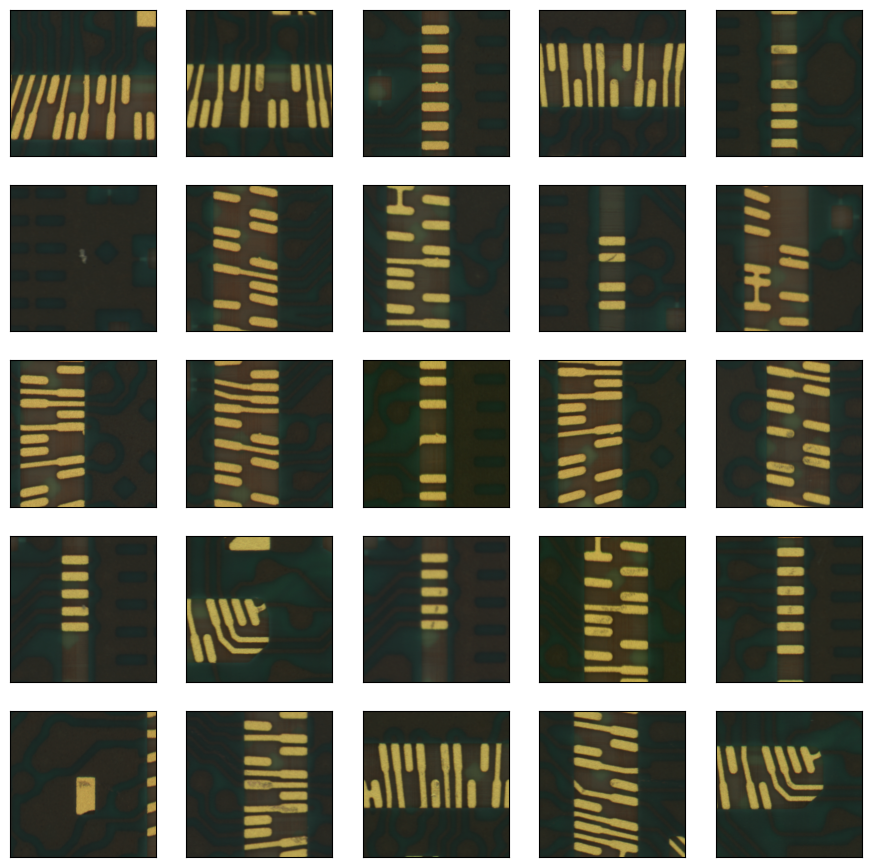

In [29]:
plt.figure(figsize=(11,11))

indices_00 =indices[(y_true==0)&(y_pred==0)] 
perm = np.random.permutation(indices_00)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

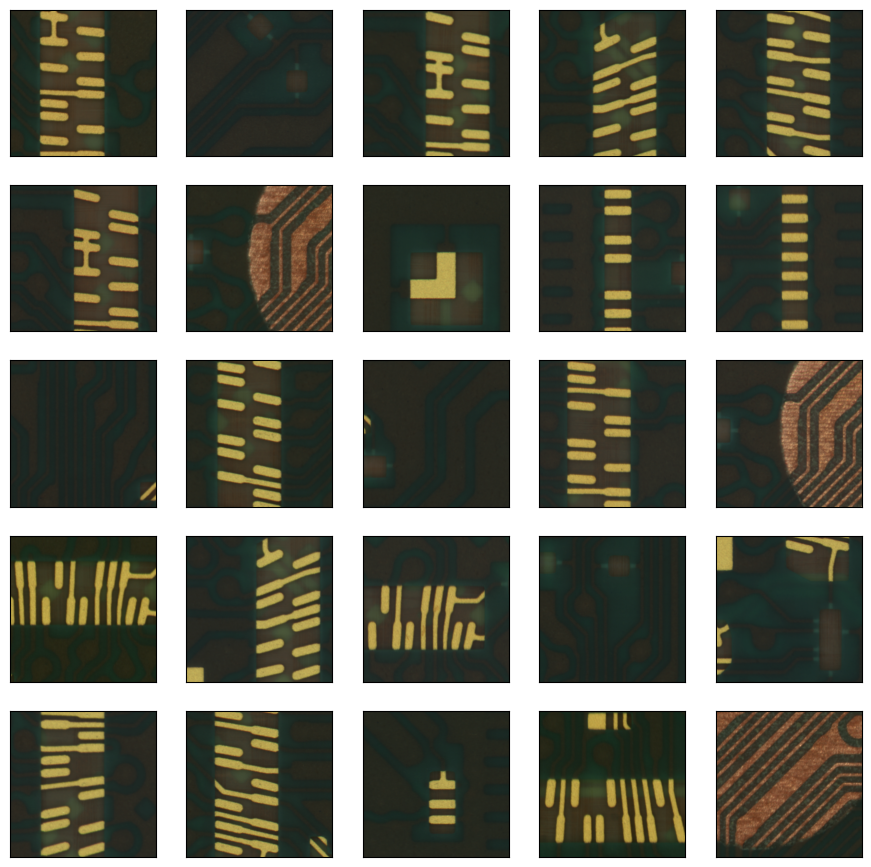

In [30]:
plt.figure(figsize=(11,11))

indices_11 =indices[(y_true==1)&(y_pred==1)] 
perm = np.random.permutation(indices_11)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

In [37]:
import glob
import numpy as np
image_files = np.array(sorted(glob.glob('PCB_data/*/*.jpg')))
image_labels = np.array([ 0 if filename.split('/')[1]=='NG' else 1 for filename in image_files])
train_ratio = 0.8
val_ratio = 0.1
n_all = len(image_labels)
n_ng = len(image_labels[image_labels==0])
n_ok = n_all - n_ng
ng_indices = np.array([i for i in range(n_ng)])
ok_indices = np.array([i for i in range(n_ng, n_all)])
np.random.seed(42)
ng_perm = np.random.permutation(ng_indices)
n_ng_train = int(n_ng*0.8)
n_ng_val = int(n_ng*0.1)
ng_train_indices = ng_perm[:n_ng_train]
ng_val_indices = ng_perm[n_ng_train:n_ng_train+n_ng_val]
ng_test_indices = ng_perm[n_ng_train+n_ng_val:]
ok_perm = np.random.permutation(ok_indices)
n_ok_train = int(n_ok*0.8)
n_ok_val = int(n_ok*0.1)
ok_train_indices = ok_perm[:n_ok_train]
ok_val_indices = ok_perm[n_ok_train:n_ok_train+n_ok_val]
ok_test_indices = ok_perm[n_ok_train+n_ok_val:]
train_indices = np.concatenate((ng_train_indices, ok_train_indices))
val_indices = np.concatenate((ng_val_indices, ok_val_indices))
test_indices = np.concatenate((ng_test_indices, ok_test_indices))


In [29]:
ok_indices

array([10154, 10155, 10156, ..., 12755, 12756, 12757])

array([0, 0, 0, ..., 0, 0, 0])